# CMB Lensing Map Simulations Code

## Importing necessary modules.
#### Order matters here. The code breaks if you import pymaster after numpy or matplotlib.

In [1]:
# Import modules 
import pymaster as nmt
#import healpy
# If you prefer to work on spherical geometry you can use HEALPix/healpy -> conda install healpy -c conda-forge or pip install healpy
#Important! If you are using this in a notebook, import pymaster *before* any matplotlib/numpy to avoid OpenMP conflicts

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib
%matplotlib inline

In [2]:
import flatmaps as fm
from astropy.wcs import WCS
from scipy.interpolate import interp1d

## Importing spectrum generated by CAMB

In [3]:
#Loading in the spectra generated by CAMB
#https://camb.info/readme.html
l, clTTa, clEEa, clTEa, clPPa, clPTa = np.loadtxt("planck_2018_cl/base_plikHM_TTTEEE_lowl_lowE_lensing_scalCls.dat", unpack=True)

In [4]:
#Spectra are respectively:
#Temperature-Temperature, E mode-E mode, Temperature-E mode cross spectrum, Phi-Phi, Phi-Temperature cross
#CAMB includes some scaling for each of these spectra, which I remove here
clTT = clTTa /((l*(l+1)/(2*np.pi)))
clEE = clEEa /((l*(l+1)/(2*np.pi)))
clTE = clTEa /((l*(l+1)/(2*np.pi)))
clPP = clPPa / (l**4 * (2.726 * 1e6)**2)
clPT = clPTa / (l**4)
cl_input = [clTT, clEE, clTE, clPP, clPT]

In [5]:
#Adding 0's to the start of the spectrum.
#The simulation code, synfast_flat, interprets the first two numbers as the 0- and 1-mode.
#Since our spectrum starts at the second mode, I set the amplitude for the 0-mode and 1-mode to 0.
clPP_0 = np.concatenate(([0,0],clPP))
l_0 = np.concatenate(([0,1],l))

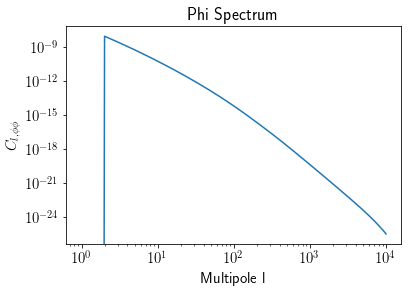

In [6]:
#The input spectrum that we will use for our simulations
plt.rc('text', usetex = True)
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.rc('axes', titlesize=17)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('figure', titlesize=18)  # fontsize of the figure title
plt.plot(l_0,clPP_0)
plt.title("Phi Spectrum")
plt.xlabel("Multipole l")
plt.ylabel("$C_{l, \phi \phi}$")
plt.xscale("log")
plt.yscale("log")

## Defining Map Parameters

In [7]:
# Create the empty map object with the resolution that we want
# Set parameters for empy map with resolution

pixels = 192. #192 pixels on each side
side = 5 #5 degrees on each side

reso = side/pixels 
reso_arcmin = reso*60
dx = reso*np.pi/180.0 #Resolution in radians

lmax = 180./reso #Maximum l-mode achievable given these parameters
lstep = lmax*2/pixels

tfac = dx/pixels #converts from pixels to radians

In [8]:
#Generate the WCS (world coordinate system) for the flatmap
w = WCS(naxis=2)
nx = int(pixels)
ny = int(pixels) 

w.wcs.crpix = [nx/2, ny/2] #Center pixel X, Y
w.wcs.cdelt = np.array([-reso, reso])
w.wcs.crval = [0, 0] #Center coordinates RA, DEC at 0,0
w.wcs.ctype = ["RA---AIR", "DEC--AIR"] #Airy projection; can be adjusted. Previous used Azimuthal equal-area

In [9]:
# This is the map object that will be used to generate the fake CMB maps
fmi = fm.FlatMapInfo(w, nx=nx, ny=ny, lx=side, ly=side) 

## Generating simulation

In [10]:
#Function that generates the simulation
phi_map = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP_0],[0], seed = 100)
#The inputs are: pixels in x- and y-directions, length of side in radians, spectra, spin of simulated map, random seed

The specific function used is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/master/src/nmt_field_flat.c#L431

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate # of maps to be calculated for each spin and each spectrum (and # of spectra associated)

-Calculate ALMs using fs_synalm:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

-Loop through the ALMs to and convert from the spectra to the map using fs_alm2map:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L220

-Return the maps

The ALMs function is found (in C) here:
https://github.com/LSSTDESC/NaMaster/blob/f8df4c4bd24c4fc5eee0e2228b283a97d259231a/src/flatsky_utils.c#L454

The function works by:

-Taking in map parameters, spectra, spins for associated maps, and a random seed

-Calculate maximum achievable l-mode (lmax), set to inv_dkvol (I think, inv_dkvol has the same calculation as my lmax)

-Looping over each pixel and calculating the associated mode in x-, y- directions and their geometric average (overall mode)

-Calculate the associated amplitude given the input spectrum (spectrum is splined, then overall mode fed to spline)

-Calculate "true" spectrum value as 1/2*lmax*input spectrum amplitude (But why is this the value?)

-Generate randomn numbers using rng_gauss, incorporate it using gsl_matrix_set

-Calculate the beam pattern by splining and evaluating inputted beam

-Multiplies the beam pattern against vector containing random numbers, sets this to real and imaginary parts of A

-Setting Alms to these values for different frequency values

-Returns Alms

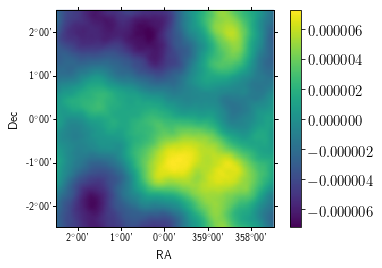

In [11]:
#Demo of randomly generated map
fmi.view_map(phi_map[0].flatten()) 

## Calculating Spectrum

### Calculating FFT & Power Spectrum

Text(0.5,1,'Logscale Phi Map FFT')

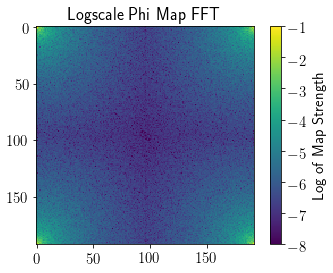

In [12]:
#This needs to be an rfft for the actual analysis and a complex fft for estimating spectra
phi_map_fft = np.fft.fft2(phi_map[0])

#max and min amplitudes for plot scaling purposes
minimum = np.amin(abs(phi_map_fft))
maximum = np.amax(abs(phi_map_fft))

plt.imshow(np.log10(np.abs(phi_map_fft)), vmin=-8, vmax=-1)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale Phi Map FFT")

#np.save("phi_map_fft_0-mode", phi_map_fft)

In [13]:
#Taking the conjugate of the phi map fft
phi_map_fft_conj = np.conj(phi_map_fft)

In [14]:
#Calculating the 2D Map Power
map_power_2D = phi_map_fft*phi_map_fft_conj*tfac**2

Text(0.5,1,'Logscale 2D Power Map')

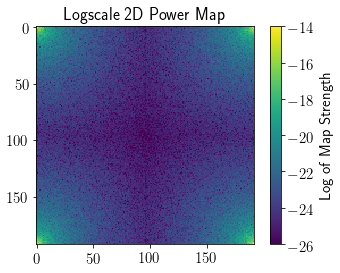

In [15]:
#Plotting 2D Map power
plt.imshow(np.log10(np.abs(map_power_2D)), vmin=-26, vmax=-14)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale 2D Power Map")

### Diving 2D Power Map into 4 quarters for summing

In [16]:
#Dividing data into four quarters, rotating so lowest mode is in top left quarter
quarter1 = map_power_2D[:int(pixels/2),:int(pixels/2)]

quarter2 = map_power_2D[:int(pixels/2),int(pixels/2+1):]
quarter2 = np.rot90(quarter2)

quarter3 = map_power_2D[int(pixels/2+1):,:int(pixels/2)]
quarter3 = np.rot90(quarter3, k=3)

quarter4 = map_power_2D[int(pixels/2+1):,int(pixels/2+1):]
quarter4 = np.rot90(quarter4, k=2)

Text(0.5,1,'Logscale 2D Power Map')

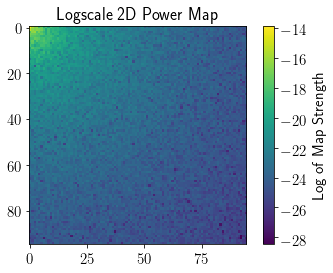

In [17]:
#Example of one of the four quarters of 2D power map
plt.imshow(np.log10(np.abs(quarter4)))#, vmin=-15, vmax=-5)
plt.colorbar(label="Log of Map Strength")
plt.title("Logscale 2D Power Map")

### Setting Parameters/Defining Arrays for Calculating Spectrum

In [18]:
#Setting the parameters for the calculating the spectrum
#Number of bins/number of annuli to be summed over (should this necessarily be less than pixels/2?)
bin_num = 80

#Highest l-mode achievable, 192 pixels, divided into 4 quarters, with lstep = 72
peak_l = pixels/2*72

#Creating empty arrays:
spectra_est = np.zeros((bin_num)) #spectum sum before averaging
spectra_est_avg_bins = np.zeros((bin_num)) #spectrum estimate after averaging
n = np.zeros((bin_num))#number of points going into each bin/annulus

#Defining edges of bins
bin_edges = np.linspace(0,np.sqrt(2)*peak_l, bin_num+1) #realized that since we're doing sqrt of sum it'll be sqrt(2)*192*72

#Defining width of 1 bin
bin_step = bin_edges[1]

#Calculating bin centers
bin_centers = (bin_edges[1:]+bin_edges[:-1])/2


### Summing over each annulus for all four quarters

In [19]:
#Creating array containing each quarter of data
quarter_list = [quarter1, quarter2, quarter3, quarter4]

#Looping over each quarter
for quarter in quarter_list:
    
    #Looping over row
    for i, spec in enumerate(quarter):
        lx_ = 72.*i #the l-mode in the x-direction
    
        #Looping over each pixel in each row
        for j, pwr in enumerate(quarter):
            
            ly_ = 72.*j #the l-mode in the y-direction
            
            #Calculate overall l-mode for each pixel
            point_on_circ = np.sqrt(lx_**2+ly_**2) #overall l-mode

            #Determine which been l-mode belongs to by seeing which is the largest lefthand edge smaller than pixel's overall l-mode
            left_bin_edge = np.where(bin_edges <= point_on_circ)[0][-1] #largest bin that's smaller than overall l-mode
            
            #Add power from that pixel to spectrum estimate
            spectra_est[left_bin_edge] += map_power_2D[i,j] #adding power at coordinate (i,j) to bin
            
            #Tally the pixel as being in this particular been (for averaging later)
            n[left_bin_edge] += 1 #counting the number of points in the bin for averaging later
            

/Users/samanthausman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:23: ComplexWarning: Casting complex values to real discards the imaginary part


In [20]:
#Divide the spectrum by the number of pixels that went into each bin
spectra_est_avg_bins = spectra_est / n

### Plotting estimated spectrum, Comparing to input spectrum

Text(0,0.5,'$C_{l, \\phi \\phi}$')

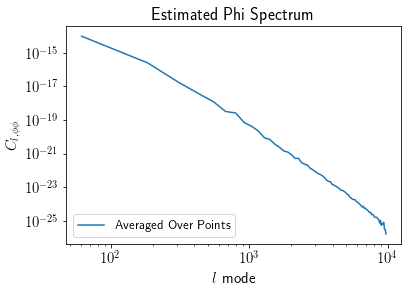

In [21]:
#Approximate spectrum
#Lowest mode is determined by smallest l measurable (determined by bin width (determined by # of bins))
plt.plot(bin_centers,spectra_est_avg_bins,label="Averaged Over Points")
plt.legend(loc="lower left")
plt.yscale("log")
plt.xscale("log")
plt.title("Estimated Phi Spectrum")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")

Text(0,0.5,'$C_{l, \\phi \\phi}$')

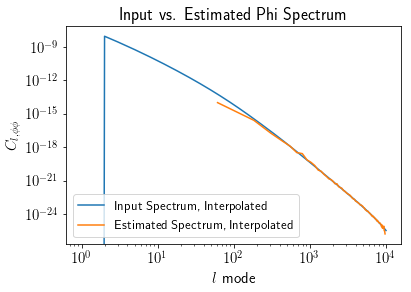

In [22]:
#Spline data to compare input spectrum to estimated spectrum
f1 = interp1d(l_0, clPP_0, kind="nearest")
f2 = interp1d(bin_centers, spectra_est_avg_bins, kind="nearest")
plt.plot(l_0, f1(l_0), label="Input Spectrum, Interpolated")
plt.plot(bin_centers, f2(bin_centers), label="Estimated Spectrum, Interpolated")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="lower left")
plt.title("Input vs. Estimated Phi Spectrum")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")

Text(0,0.5,'$C_{l, \\phi \\phi}$')

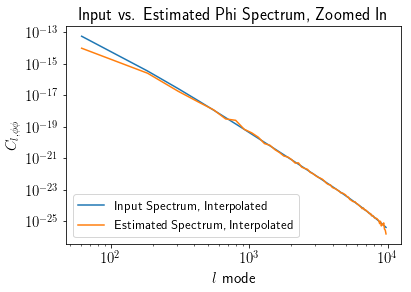

In [23]:
#Zooming in on above plot to domain which both spectra are valid
plt.plot(bin_centers, f1(bin_centers), label="Input Spectrum, Interpolated")
plt.plot(bin_centers, f2(bin_centers), label="Estimated Spectrum, Interpolated")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="lower left")
plt.title("Input vs. Estimated Phi Spectrum, Zoomed In")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")

Text(0,0.5,'$C_{l, \\phi \\phi}$')

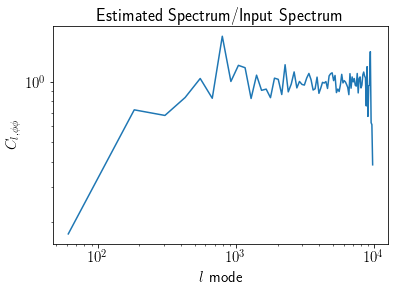

In [24]:
#Calculating the fractional change between the two
plt.plot(bin_centers, f2(bin_centers)/f1(bin_centers))
plt.xscale("log")
plt.yscale("log")
plt.title("Estimated Spectrum/Input Spectrum")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")

## Testing Spectrum Estimate Against Joao's Method

##### Joao's method of spectrum estimation histograms each pixel then weights its contribution 

In [25]:
#Defining bin sizes
binsize = np.sqrt(2)*np.pi/(dx*pixels)
lbins = np.arange(binsize, lmax, binsize)
cbins = 0.5*(lbins[0:-1] + lbins[1:])

In [26]:
#Create grid to define l-mode in x- and y-directions and overall l as their geometric sum
lx, ly = np.meshgrid(np.linspace(-lmax+lstep, lmax, pixels),np.linspace(-lmax+lstep, lmax, pixels))
ell = np.sqrt(lx**2 + ly**2)

/Users/samanthausman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  


In [27]:
#Histogramming l-modes into bins for normalization later 
norm, bins = np.histogram(ell, bins=bin_edges)
norm = norm.astype(float)
norm[ np.where(norm != 0.0) ] = 1./norm[ np.where(norm != 0.0) ]

In [28]:
#Create 2D power map
phi_map_real_fft = np.fft.fft2(phi_map[0])
phi_map_real_fft_conj = np.conj(phi_map_real_fft)
real_map_power_2D = phi_map_real_fft*phi_map_real_fft_conj
#"spectrum_2D" is the same as the powermap but recentered so the 0-mode is in the middle
spectrum_2D = np.fft.fftshift(real_map_power_2D*tfac**2)

In [29]:
#Histogramming l-modes from above, weighting by the 2D powerspectrum
joao_spectrum, bins = np.histogram(ell, bins=bin_edges,weights=spectrum_2D)

#Normalizing to account for different number of l-modes in eac bin
joao_spectrum *= norm

/Users/samanthausman/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


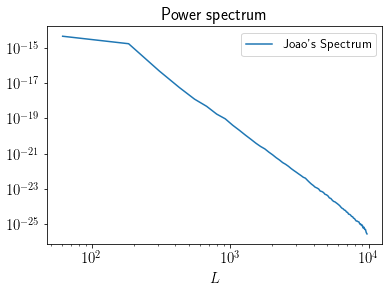

<Figure size 432x288 with 0 Axes>

In [30]:
#Plot the spectrum
plt.figure()
plt.xlabel('$L$')
plt.title('Power spectrum')
plt.yscale('log')
plt.xscale("log")
plt.plot(bin_centers, joao_spectrum, label="Joao's Spectrum")
plt.legend()
plt.show()
plt.clf()

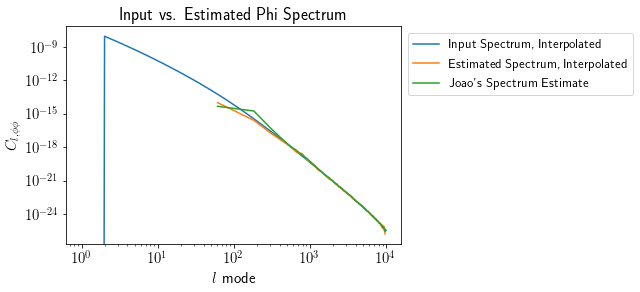

In [31]:
#Compare with the input spectrum and my estimated spectrum splined earlier
fig = plt.figure()
ax = plt.subplot(111)
plt.plot(l_0, f1(l_0), label="Input Spectrum, Interpolated")
plt.plot(bin_centers, f2(bin_centers), label="Estimated Spectrum, Interpolated")
plt.plot(bin_centers, joao_spectrum, label="Joao's Spectrum Estimate")
plt.xscale("log")
plt.yscale("log")
plt.title("Input vs. Estimated Phi Spectrum")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")
ax.legend(bbox_to_anchor=(1.0, 1.0))

Text(0,0.5,'$C_{l, \\phi \\phi}$')

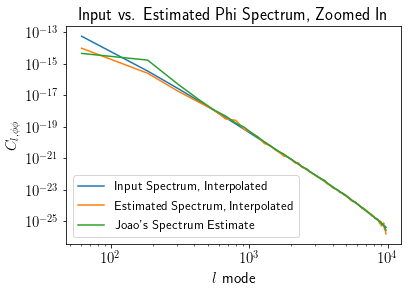

In [32]:
#Zooming in on above plot to domain which both spectra are valid
plt.plot(bin_centers, f1(bin_centers), label="Input Spectrum, Interpolated")
plt.plot(bin_centers, f2(bin_centers), label="Estimated Spectrum, Interpolated")
plt.plot(bin_centers, joao_spectrum, label="Joao's Spectrum Estimate")
plt.xscale("log")
plt.yscale("log")
plt.legend(loc="lower left")
plt.title("Input vs. Estimated Phi Spectrum, Zoomed In")
plt.xlabel("$l$ mode")
plt.ylabel("$C_{l, \phi \phi}$")

## Generate 11,200 Maps for ML Code

In [ ]:
#For generating/saving all the maps once testing is over
num_maps = 11200
i=0
all_maps = np.zeros([num_maps,int(pixels),int(pixels)/2+1])
while i < num_maps:
    map_gen = nmt.synfast_flat(int(fmi.nx),int(fmi.ny),fmi.lx_rad,fmi.ly_rad, [clPP],[0], seed = i)
    phi_map_fft = np.fft.rfft2(phi_map[0])
    all_maps[i] = phi_map_fft
    if np.mod(i,100) == 0:
        print i,
    i+=1

In [ ]:
np.save("./all_phi_map_ffts", all_maps)